### Create Multi-Label Targets:

Convert the list of labels into a multi-hot encoded format using MultiLabelBinarizer from scikit-learn

In [7]:
import json
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import numpy as np

In [2]:
# --- (1) Load JSON Data ---
def load_license_data(json_folder):
    """Loads license data from JSON files.

    Args:
        json_folder: Path to the folder containing the JSON files.

    Returns:
        A list of dictionaries, where each dictionary represents a license
        and contains its name, family, labels, and text.
    """
    license_data = []
    for filename in os.listdir(json_folder):
        if filename.endswith(".json"):
            license_name = filename[:-5]  # Remove ".json" extension
            filepath = os.path.join(json_folder, filename)
            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)
                license_data.append({
                    "license_name": license_name,
                    "family": data["family"],
                    "labels": data["labels"],
                    "text": data["text"],
                })
    return license_data

In [3]:
json_folder = "../../data/processed/preprocessed_licenses_json"  # Replace with your folder path
license_data = load_license_data(json_folder)

In [4]:
df = pd.DataFrame(license_data)

In [5]:
df.head()

,license_name,family,labels,text
0,0BSD,permissive,[Display copyright notice (obligation/INFORMAT...,copyright c year by author email permission to...
1,AdaCore-doc,permissive,[Declare modification in source code (obligati...,"this document may be copied, in whole or in pa..."
2,AFL-1.1,permissive,[Display copyright notice (obligation/INFORMAT...,academic free license version 1.1 the academic...
3,AFL-1.2,permissive,[Declare modification in source code (obligati...,academic free license version 1.2 this academi...
4,AFL-2.0,permissive,[Display copyright notice (obligation/INFORMAT...,the academic free license v. 2.0 this academic...


In [6]:
mlb = MultiLabelBinarizer()

# --- (5) Fit and Transform ---
# Fit the MultiLabelBinarizer on the "labels" column (from JSON)
multi_hot_labels = mlb.fit_transform(df["labels"])

In [8]:
np.savez("../mlb.npz", classes=mlb.classes_)

In [11]:

# --- (6) Add Multi-Hot Encoded Labels to DataFrame ---
df["multi_hot_labels"] = list(multi_hot_labels)

# --- (7) Store the Number of Classes ---
num_labels = len(mlb.classes_)
print(f"Number of unique labels: {num_labels}")
print(f"Classes: {mlb.classes_}")

# --- (8) Convert to PyTorch Tensor ---
labels = torch.tensor(multi_hot_labels, dtype=torch.float)

Number of unique labels: 29
Classes: ['Anti-DRM (obligation/WARNING)' 'Anti-Tivoization (obligation/WARNING)'
 'Copyleft (network protective) (obligation/ALARM)'
 'Copyleft (strong) (obligation/WARNING)'
 'Copyleft (weak) (obligation/WARNING)'
 'Declare modification in source code (obligation/WARNING)'
 'Deprecated License (other/INFORMATION)'
 'Display acknowledgement message (obligation/WARNING)'
 'Display additional information (obligation/WARNING)'
 'Display copyright notice (obligation/INFORMATION)'
 'Display license in binary (obligation/INFORMATION)'
 'Display license in the source (obligation/INFORMATION)'
 'Doing Business with US (other/ALARM)'
 'Endorsement prohibited (prohibition/INFORMATION)'
 'Jurisdiction specific (other/WARNING)'
 'Keep copy of source code available (obligation/WARNING)'
 'License upgrade allowed (right/INFORMATION)'
 'Limitation (limitation/WARNING)'
 'No further restrictions permitted (prohibition/INFORMATION)'
 'Patent grant (other/INFORMATION)' 'Perm

In [12]:
print(df[["license_name", "labels", "multi_hot_labels"]].head())

  license_name                                             labels  \
0         0BSD  [Display copyright notice (obligation/INFORMAT...   
1  AdaCore-doc  [Declare modification in source code (obligati...   
2      AFL-1.1  [Display copyright notice (obligation/INFORMAT...   
3      AFL-1.2  [Declare modification in source code (obligati...   
4      AFL-2.0  [Display copyright notice (obligation/INFORMAT...   

                                    multi_hot_labels  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...  
3  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, ...  


### Model Preparation

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, ElectraConfig

model_name = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Create a new configuration with the desired max_position_embeddings
config = ElectraConfig.from_pretrained(model_name)
config.max_position_embeddings = 1024
config.num_labels = num_labels
config.problem_type = "multi_label_classification"

# Reinitialize the model with the new configuration
model = AutoModelForSequenceClassification.from_config(config)

In [14]:
token_lengths = []

In [15]:
def analyze_license_lengths(df, tokenizer):
    """
    Analyzes the token lengths of license texts in a DataFrame.

    Args:
      df: Pandas DataFrame with a "text" column containing license texts.
      tokenizer: Hugging Face tokenizer.

    Returns:
      A dictionary with statistics about tokenized lengths.
    """

    for text in df["text"]:
        tokens = tokenizer.tokenize(text)
        token_lengths.append(len(tokens))

    return {
        "max_length": max(token_lengths),
        "avg_length": sum(token_lengths) / len(token_lengths),
        "min_length": min(token_lengths),
    }

Token indices sequence length is longer than the specified maximum sequence length for this model (908 > 512). Running this sequence through the model will result in indexing errors


Maximum token length: 8032
Average token length: 1574.0678733031675
Minimum token length: 36


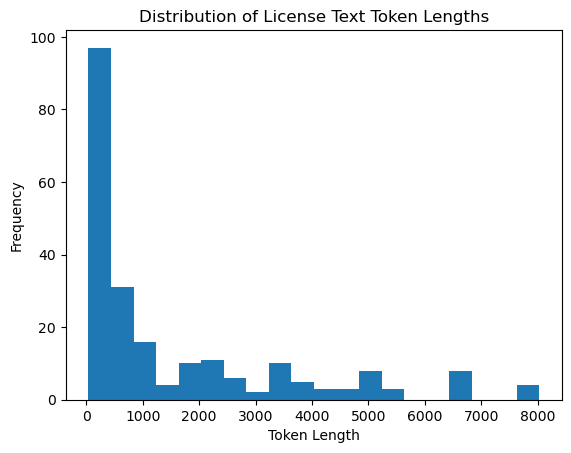

In [16]:
length_stats = analyze_license_lengths(df, tokenizer)

# Print the results
print(f"Maximum token length: {length_stats['max_length']}")
print(f"Average token length: {length_stats['avg_length']}")
print(f"Minimum token length: {length_stats['min_length']}")

# (Optional) Visualize the distribution
import matplotlib.pyplot as plt

plt.hist(token_lengths, bins=20)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of License Text Token Lengths")
plt.show()

In [17]:
encoded_inputs = tokenizer(
    df["text"].tolist(),  # Tokenize the "text" column
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=1024 # Adjust max_length as needed
)

In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Get the multi-hot encoded labels as a tensor (we created this in 2.1.4)
labels = torch.tensor(df["multi_hot_labels"].tolist(), dtype=torch.float)

dataset = TensorDataset(
    encoded_inputs["input_ids"],
    encoded_inputs["attention_mask"],
    labels
)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)  # Adjust batch size

C:\Users\NPARSHO\AppData\Local\Temp\ipykernel_20036\2087723361.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  labels = torch.tensor(df["multi_hot_labels"].tolist(), dtype=torch.float)


In [19]:
import torch.nn as nn
from transformers import AdamW

loss_fn = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=2e-5)  # Adjust learning rate (lr)

c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)
model.train()

num_epochs = 10  # Adjust the number of epochs

for epoch in range(num_epochs):
    for batch in dataloader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        loss.backward()
        optimizer.step()

        # Optional: Print training progress
        print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch: 1/10, Loss: 0.7161


In [42]:
from sklearn.metrics import classification_report, hamming_loss, accuracy_score

model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in dataloader: # Ideally, use a separate validation dataloader
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        threshold = 0.5  # Threshold for converting probabilities to predictions
        predictions = (logits > threshold).int()

        all_predictions.extend(predictions.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

# Calculate metrics (using scikit-learn)
print(classification_report(all_labels, all_predictions, target_names=mlb.classes_))
print(f"Hamming Loss: {hamming_loss(all_labels, all_predictions)}")
print(f"Exact Match Ratio: {accuracy_score(all_labels, all_predictions)}")

                                                             precision    recall  f1-score   support

                              Anti-DRM (obligation/WARNING)       0.00      0.00      0.00         6
                      Anti-Tivoization (obligation/WARNING)       0.00      0.00      0.00        13
           Copyleft (network protective) (obligation/ALARM)       0.00      0.00      0.00         8
                     Copyleft (strong) (obligation/WARNING)       0.00      0.00      0.00        29
                       Copyleft (weak) (obligation/WARNING)       0.00      0.00      0.00        49
   Declare modification in source code (obligation/WARNING)       0.84      0.67      0.75        94
                     Deprecated License (other/INFORMATION)       0.00      0.00      0.00        21
       Display acknowledgement message (obligation/WARNING)       0.00      0.00      0.00        27
        Display additional information (obligation/WARNING)       0.00      0.00      0.00

c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
def save_model(model, tokenizer, output_dir):
    """Saves the model, tokenizer, and configuration to a specified directory.

    Args:
        model: The trained model.
        tokenizer: The tokenizer.
        output_dir: The directory where the model will be saved.
    """
    print(f"Saving model to {output_dir}")
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

In [44]:
output_directory = "../model/ELECTRA"  # Replace with your desired directory
save_model(model, tokenizer, output_directory)

Saving model to ../model/ELECTRA


In [38]:
from sklearn.model_selection import train_test_split

# Assuming your data is in the DataFrame 'df'

# Split into training and temp (validation + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80/20 split

# Split temp into validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50/50 split (10/10)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 176
Validation set size: 22
Test set size: 23


In [40]:
# Tokenize validation data
val_encoded_inputs = tokenizer(
    val_df["text"].tolist(),
    padding=True,
    truncation=True,
    return_tensors="pt",
    max_length=1024
)

# Create validation labels
val_labels = torch.tensor(val_df["multi_hot_labels"].tolist(), dtype=torch.float)

# Create validation dataset and dataloader
val_dataset = TensorDataset(
    val_encoded_inputs["input_ids"],
    val_encoded_inputs["attention_mask"],
    val_labels
)

val_dataloader = DataLoader(val_dataset, batch_size=8)  # Adjust batch size

In [45]:
import numpy as np
from sklearn.metrics import f1_score

def optimize_thresholds(model, dataloader, device, metric="f1_micro"):
    """Optimizes the prediction thresholds for each label based on a validation set.

    Args:
        model: The trained model.
        dataloader: The validation set dataloader.
        device: The device (CPU or GPU).
        metric: The metric to optimize ("f1_micro", "f1_macro", "f1_samples", "hamming", "exact_match").

    Returns:
        A tuple containing:
        - best_thresholds: A list of the best thresholds found for each label.
        - best_score: The best score achieved with the best thresholds.
    """
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)  # Apply sigmoid to get probabilities

            all_probs.extend(probs.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    num_labels = all_labels.shape[1]
    best_thresholds = [0.5] * num_labels  # Initialize with default threshold
    best_score = 0

    # Iterate over each label and find the best threshold
    for i in range(num_labels):
        best_threshold = 0.5
        if metric.startswith("f1_"):
            best_score = -1  # For F1, higher is better
        elif metric == "hamming":
            best_score = float('inf')  # For Hamming loss, lower is better
        else:
            best_score = -1
        
        for threshold in np.arange(0.1, 0.9, 0.05):  # Search in increments of 0.05
            predictions = (all_probs[:, i] >= threshold).astype(int)
            
            if metric == "f1_micro":
                score = f1_score(all_labels[:, i], predictions, average="micro", zero_division=0)
            elif metric == "f1_macro":
                score = f1_score(all_labels[:, i], predictions, average="macro", zero_division=0)
            elif metric == "f1_samples":
                score = f1_score(all_labels[:, i], predictions, average="samples", zero_division=0)
            elif metric == "hamming":
                score = hamming_loss(all_labels[:, i], predictions)
            elif metric == "exact_match":
                score = accuracy_score(all_labels[:, i], predictions)  # Not ideal for threshold tuning

            if metric.startswith("f1_") or metric == "exact_match":
                if score > best_score:
                    best_score = score
                    best_threshold = threshold
            elif metric == "hamming":
                if score < best_score:
                    best_score = score
                    best_threshold = threshold

        best_thresholds[i] = best_threshold

    # Calculate the overall score with the best thresholds
    final_predictions = (all_probs >= np.array(best_thresholds)).astype(int)
    if metric == "f1_micro":
        best_overall_score = f1_score(all_labels, final_predictions, average="micro", zero_division=0)
    elif metric == "f1_macro":
        best_overall_score = f1_score(all_labels, final_predictions, average="macro", zero_division=0)
    elif metric == "f1_samples":
        best_overall_score = f1_score(all_labels, final_predictions, average="samples", zero_division=0)
    elif metric == "hamming":
        best_overall_score = hamming_loss(all_labels, final_predictions)
    elif metric == "exact_match":
        best_overall_score = accuracy_score(all_labels, final_predictions)

    return best_thresholds, best_overall_score
# Example Usage
best_thresholds, best_score = optimize_thresholds(model, val_dataloader, device, metric="f1_micro")

print(f"Best Thresholds: {best_thresholds}")
print(f"Best F1 Score (micro): {best_score:.4f}")
# or print(f"Best Hamming Loss: {best_score:.4f}")

Best Thresholds: [0.15000000000000002, 0.25000000000000006, 0.15000000000000002, 0.15000000000000002, 0.30000000000000004, 0.25000000000000006, 0.25000000000000006, 0.20000000000000004, 0.1, 0.1, 0.1, 0.1, 0.25000000000000006, 0.6000000000000002, 0.1, 0.45000000000000007, 0.25000000000000006, 0.1, 0.25000000000000006, 0.15000000000000002, 0.25000000000000006, 0.40000000000000013, 0.1, 0.20000000000000004, 0.30000000000000004, 0.1, 0.1, 0.1, 0.45000000000000007]
Best F1 Score (micro): 0.8747


In [46]:
def analyze_errors(model, dataloader, device, label_names, best_thresholds):
    """Analyzes the errors made by the model on the given dataloader.

    Args:
        model: The trained model.
        dataloader: The dataloader containing the evaluation data.
        device: The device (CPU or GPU).
        label_names: A list of label names.
        best_thresholds: A list of the best thresholds for each label.
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_texts = []  # Store the texts for analysis

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Get the text corresponding to the input IDs
            texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
            all_texts.extend(texts)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)

            # Apply the best thresholds to get predictions
            predictions = (probs > torch.tensor(best_thresholds).to(device)).int()

            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # (1) Classification Report (per label)
    print(classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0))

    # (2) Confusion Matrix (per label)
    for i, label_name in enumerate(label_names):
        cm = confusion_matrix(all_labels[:, i], all_predictions[:, i])
        print(f"\nConfusion Matrix for label: {label_name}")
        print(cm)

    # (3) Examine Misclassified Examples
    print("\nMisclassified Examples:")
    for i in range(len(all_texts)):
        if (all_predictions[i] != all_labels[i]).any():  # If any label is misclassified
            print(f"\nText: {all_texts[i]}")
            print(f"True Labels: {[label_names[j] for j in range(len(label_names)) if all_labels[i][j] == 1]}")
            print(f"Predicted Labels: {[label_names[j] for j in range(len(label_names)) if all_predictions[i][j] == 1]}")
            # You can add more detailed analysis here, such as:
            # - Which labels were incorrectly predicted?
            # - What were the predicted probabilities for those labels?

# Example Usage:
from sklearn.metrics import confusion_matrix
analyze_errors(model, val_dataloader, device, mlb.classes_, best_thresholds)  # Assumes you have mlb (MultiLabelBinarizer) from before

                                                             precision    recall  f1-score   support

                              Anti-DRM (obligation/WARNING)       0.00      0.00      0.00         0
                      Anti-Tivoization (obligation/WARNING)       0.00      0.00      0.00         1
           Copyleft (network protective) (obligation/ALARM)       0.00      0.00      0.00         0
                     Copyleft (strong) (obligation/WARNING)       0.50      1.00      0.67         3
                       Copyleft (weak) (obligation/WARNING)       0.50      0.60      0.55         5
   Declare modification in source code (obligation/WARNING)       0.90      0.69      0.78        13
                     Deprecated License (other/INFORMATION)       0.00      0.00      0.00         4
       Display acknowledgement message (obligation/WARNING)       0.00      0.00      0.00         1
        Display additional information (obligation/WARNING)       0.71      1.00      0.83

c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\NPARSHO\AppData\Local\anaconda3\envs\cuda2\Lib\site-packages\sklearn\metrics\_classification.py:409: Us

In [48]:
def evaluate_model(model, dataloader, device, label_names, best_thresholds):
    """Evaluates a loaded model on a given dataloader.

    Args:
        model: The loaded model.
        dataloader: The dataloader containing the evaluation data.
        device: The device (CPU or GPU).
        label_names: A list of label names.
        best_thresholds: The optimized thresholds for each label.

    Returns:
        A dictionary containing the evaluation metrics.
    """
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)

            # Apply the best thresholds
            predictions = (probs > torch.tensor(best_thresholds).to(device)).int()

            all_predictions.extend(predictions.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    # Calculate metrics
    report = classification_report(all_labels, all_predictions, target_names=label_names, zero_division=0)
    hamming = hamming_loss(all_labels, all_predictions)
    exact_match = accuracy_score(all_labels, all_predictions)

    return {
        "classification_report": report,
        "hamming_loss": hamming,
        "exact_match_ratio": exact_match,
    }

# Example Usage:
# Assuming you have already loaded the model and tokenizer as 'loaded_model' and 'loaded_tokenizer'
# and you have your validation dataloader as 'val_dataloader'

val_metrics = evaluate_model(model, val_dataloader, device, mlb.classes_, best_thresholds)

print("Validation Metrics (Loaded Model):")
print(val_metrics["classification_report"])
print(f"Hamming Loss: {val_metrics['hamming_loss']:.4f}")
print(f"Exact Match Ratio: {val_metrics['exact_match_ratio']:.4f}")

Validation Metrics (Loaded Model):
                                                             precision    recall  f1-score   support

                              Anti-DRM (obligation/WARNING)       0.00      0.00      0.00         0
                      Anti-Tivoization (obligation/WARNING)       0.00      0.00      0.00         1
           Copyleft (network protective) (obligation/ALARM)       0.00      0.00      0.00         0
                     Copyleft (strong) (obligation/WARNING)       0.50      1.00      0.67         3
                       Copyleft (weak) (obligation/WARNING)       0.50      0.60      0.55         5
   Declare modification in source code (obligation/WARNING)       0.90      0.69      0.78        13
                     Deprecated License (other/INFORMATION)       0.00      0.00      0.00         4
       Display acknowledgement message (obligation/WARNING)       0.00      0.00      0.00         1
        Display additional information (obligation/WARN